# Outline

- create a model that predicts the category of each article by Neural Network
- train data is `matichon.json` that contains about 17K articles of Thai news by Matichon between 2015-2018
- X is `article`, using `CountVectorizer` and `TfidfVectorizer`
- y is news category (10 labels)
- F1 score of Logistic Regression using articles : **0.80**

# Import

In [1]:
import pandas as pd
import numpy as np
import re, collections

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model, to_categorical

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from pythainlp.tokenize import word_tokenize

- custom tokenization function
- remove all quatations and shrink newlines `\n` and white spaces 
- input is tokenized sentence (list of str)

In [2]:
def my_tokenize(text):
    text = re.sub(r'[\"\']', '', text) # remove quotations
    text = re.sub(r'[\n\t\s]', ' ', text) # shrink newlines/spaces/tabs
    tokens = word_tokenize(text, keep_whitespace=False)
    return ' '.join(tokens) # join with space because CountVectorizer takes sentences as str

# Load data

- target variable is `category`
- `headline` and `article` are untokenized text

In [3]:
df = pd.read_json('data/matichon.json')
df

,headline,article,date,category,url,id
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,2015-12-04 03:35:18,foreign,https://www.matichon.co.th/foreign/news_293,293
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...","""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",2015-12-04 04:10:49,politics,https://www.matichon.co.th/politics/news_329,329
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,2015-12-04 06:30:11,entertainment,https://www.matichon.co.th/entertainment/news_375,375
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,2015-12-04 07:10:26,entertainment,https://www.matichon.co.th/entertainment/news_393,393
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,2015-12-05 05:26:20,entertainment,https://www.matichon.co.th/entertainment/news_445,445
...,...,...,...,...,...,...
17104,โบว์ ณัฏฐา แจ้งความ พล.ต.อ.ศรีวราห์ ถูกพาดพิง...,เมื่อวันที่ 5 ก.ค. ที่ สน.พญาไท น.ส.ณัฏฐา มหัท...,2018-07-05 13:25:45,politics,https://www.matichon.co.th/politics/news_1029607,1029607
17105,ภาพบรรยากาศ ขุดทางระบายน้ำ เร่งนำ 13 ชีวิตออกจ...,วันที่ 5 กรกฎาคม เจ้าหน้าที่ขุดทางระบายน้ำที่ด...,2018-07-05 13:33:10,region,https://www.matichon.co.th/region/news_1029619,1029619
17106,สนช.ผ่านพ.ร.บ.สงฆ์ 3 วาระรวด พระมหากษัตริย์ทรง...,"สนช.ผ่าน พ.ร.บ.สงฆ์ 3 วาระรวด ""วิษณุ"" แจงสาระส...",2018-07-05 13:33:27,politics,https://www.matichon.co.th/politics/news_1029636,1029636
17107,นานาทรรศนะเพิ่มค่าปรับหมอ 5ล้านบ. สกัดเบี้ยว...,หมายเหตุ – จากกรณีที่ กระทรวงศึกษาธิการ (ศธ.) ...,2018-07-05 13:53:26,education,https://www.matichon.co.th/education/news_1029668,1029668


In [4]:
## drop "date", "headline", "url", and "id"
df = df.drop(columns=['date','headline','url','id'])
df.head()

,article,category
0,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,foreign
1,"""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",politics
2,แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,entertainment
3,กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,entertainment
4,แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,entertainment


In [5]:
## value counts of target variable
df.category.value_counts()

politics         3135
region           2655
crime            2141
local            1938
publicize        1481
foreign          1329
economy          1249
sport            1202
education        1053
entertainment     926
Name: category, dtype: int64

# Tokenize & train-test split

- it may take more than 2 minutes
- you can save the tokenized file by `df.to_json('XXX.json', orient='records')`

In [6]:
df['article_tokens'] = df['article'].apply(my_tokenize)

In [7]:
df.head()

,article,category,article_tokens
0,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,foreign,( 2 ธ.ค. 58 ) หนังสือพิมพ์ อัล ริยาด ของ ทางกา...
1,"""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",politics,บิ๊ก ป้อม แจง ครม. มี ความพยายาม ยุยง ปลุกปั่น...
2,แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,entertainment,แม้ จะ ทำหน้าที่ ภรรยา ที่ ดี มา เฝ้า ปอ – ทฤษ...
3,กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,entertainment,กลายเป็น ดารา หนุ่ม เนื้อ หอม แฟนคลับ แน่น กระ...
4,แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,entertainment,แสดง ดี จน เป็นที่ ถูกอกถูกใจ แฟนคลับ จน ได้รั...


In [8]:
train, test = train_test_split(df, test_size=0.15, random_state=42) # same split as Logistic Regression

print(train.shape)
print(test.shape)

(14542, 3)
(2567, 3)


# Create Index Dictionary


in order to inverse numeric output label `1` into string category `economy`

~~~python
label_2_index = {'crime':0, 'economy':1, ...}
index_2_label = {0:'crime', 1:'economy', ...}
~~~

In [9]:
label_2_index = {label:i for i, label in enumerate(sorted(df.category.unique()))}
index_2_label = {v:k for k,v in label_2_index.items()}

# create `X` and `y`

- use `CountVecrotizer`
- here, set `max_df=0.5` and `max_features=30000` (you can change the hyperparameters)

In [10]:
max_features = 30000

## Instantiate Vectorizer & transform
cv = CountVectorizer(max_df=0.5, max_features=max_features)
X_train_cv = cv.fit_transform(train['article_tokens']).todense()
X_test_cv = cv.transform(test['article_tokens']).todense()

tv = TfidfVectorizer(max_features=max_features)
X_train_tv = tv.fit_transform(train['article_tokens']).todense()
X_test_tv = tv.transform(test['article_tokens']).todense()

## make y 
## 1. to index
## 2. one-hot-encoding e.g. [[0,1,0,0...], [0,0,0,1,...], ]
y_train = [label_2_index[label] for label in train['category']]
y_train = to_categorical(y_train, num_classes=len(label_2_index))
y_test = test['category'] # not need to index

print('TRAIN CV:', X_train_cv.shape, y_train.shape)
print('TRAIN TV:', X_train_tv.shape, y_train.shape)
print('TEST  CV:', X_test_cv.shape, y_test.shape)
print('TEST  TV:', X_test_tv.shape, y_test.shape)

TRAIN CV: (14542, 30000) (14542, 10)
TRAIN TV: (14542, 30000) (14542, 10)
TEST  CV: (2567, 30000) (2567,)
TEST  TV: (2567, 30000) (2567,)


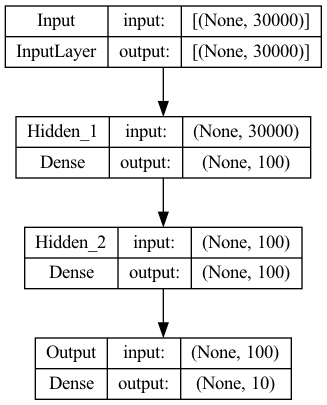

In [11]:
## Instantiate Model
model = Sequential()
model.add(Input(shape=(X_train_cv.shape[-1],), name='Input')) # input length = size of vocab
model.add(Dense(100, activation='relu', name='Hidden_1')) # 1st hidden layer
model.add(Dense(100, activation='relu', name='Hidden_2'))  # 2nd hidden layer 
model.add(Dense(10, activation='softmax', name='Output')) # output layer
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

## plot model
plot_model(model, show_shapes=True)

# Train & Predict: `CountVectorizer`

In [13]:
## fit
history = model.fit(X_train_cv, y_train, epochs=5, validation_split=0.2)

Epoch 1/5


2022-10-28 08:50:54.167222: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


364/364 [==============================] - 4s 10ms/step - loss: 0.8916 - accuracy: 0.7387 - val_loss: 0.7663 - val_accuracy: 0.7783
Epoch 2/5
364/364 [==============================] - 3s 9ms/step - loss: 0.4116 - accuracy: 0.8690 - val_loss: 0.8248 - val_accuracy: 0.7800
Epoch 3/5
364/364 [==============================] - 3s 10ms/step - loss: 0.2052 - accuracy: 0.9367 - val_loss: 1.1080 - val_accuracy: 0.7573
Epoch 4/5
364/364 [==============================] - 3s 9ms/step - loss: 0.0934 - accuracy: 0.9730 - val_loss: 1.4025 - val_accuracy: 0.7394
Epoch 5/5
364/364 [==============================] - 3s 8ms/step - loss: 0.0416 - accuracy: 0.9903 - val_loss: 1.7676 - val_accuracy: 0.7508


<AxesSubplot: xlabel='epoch'>

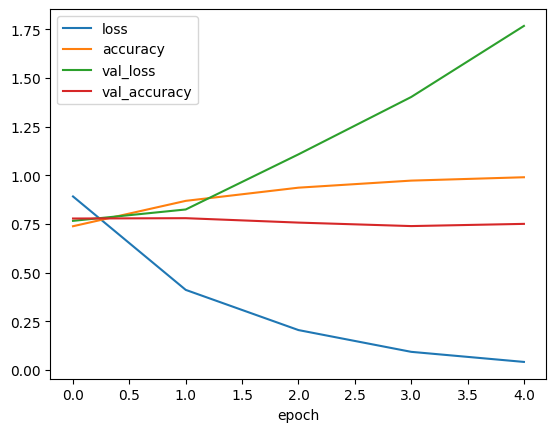

In [14]:
pd.DataFrame(history.history).plot(xlabel='epoch')

- validation loss increased = overfitting
- epoch 1-2 is enough

In [17]:
## train again with all data (no validation split)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

history = model.fit(X_train_cv, y_train, epochs=2, validation_split=0)

Epoch 1/2
455/455 [==============================] - 4s 8ms/step - loss: 0.3123 - accuracy: 0.9452
Epoch 2/2
455/455 [==============================] - 3s 7ms/step - loss: 0.1187 - accuracy: 0.9743


In [18]:
## predict
y_pred = model.predict(X_test_cv).argmax(axis=1)
y_pred = [index_2_label[i] for i in y_pred]

## print F1 scores
print(classification_report(y_test, y_pred))

81/81 [==============================] - 0s 2ms/step
               precision    recall  f1-score   support

        crime       0.66      0.70      0.68       304
      economy       0.86      0.79      0.82       181
    education       0.76      0.82      0.79       171
entertainment       0.89      0.88      0.89       144
      foreign       0.97      0.90      0.93       196
        local       0.38      0.48      0.43       283
     politics       0.87      0.91      0.89       492
    publicize       0.84      0.81      0.83       236
       region       0.67      0.50      0.57       377
        sport       0.94      0.97      0.95       183

     accuracy                           0.76      2567
    macro avg       0.78      0.78      0.78      2567
 weighted avg       0.77      0.76      0.76      2567



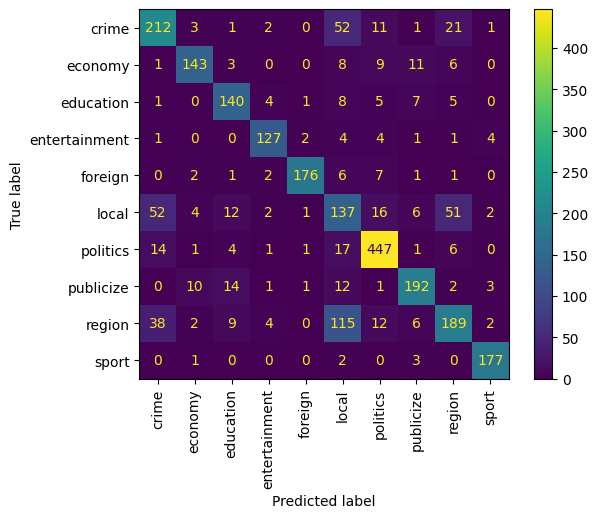

In [19]:
## print confusion matrix
labels = list(label_2_index.keys())

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90)

# Train & Predict: `TfidfVectorizer`

In [20]:
## initialize model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

## fit
history = model.fit(X_train_tv, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
364/364 [==============================] - 3s 8ms/step - loss: 0.8772 - accuracy: 0.7191 - val_loss: 0.6386 - val_accuracy: 0.7845
Epoch 2/5
364/364 [==============================] - 3s 7ms/step - loss: 0.4329 - accuracy: 0.8497 - val_loss: 0.6238 - val_accuracy: 0.7803
Epoch 3/5
364/364 [==============================] - 3s 7ms/step - loss: 0.2753 - accuracy: 0.9050 - val_loss: 0.6892 - val_accuracy: 0.7766
Epoch 4/5
364/364 [==============================] - 3s 7ms/step - loss: 0.1719 - accuracy: 0.9431 - val_loss: 0.7936 - val_accuracy: 0.7759
Epoch 5/5
364/364 [==============================] - 3s 7ms/step - loss: 0.1038 - accuracy: 0.9683 - val_loss: 0.8921 - val_accuracy: 0.7587


<AxesSubplot: xlabel='epoch'>

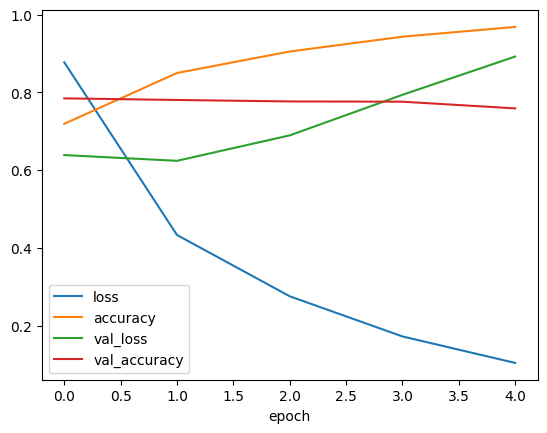

In [21]:
pd.DataFrame(history.history).plot(xlabel='epoch')

- just like as `CountVectorizer`
- validation loss increased = overfitting
- epoch 1-2 is enough

In [23]:
## train again with all data
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

history = model.fit(X_train_tv, y_train, epochs=2, validation_split=0)

Epoch 1/2
455/455 [==============================] - 3s 7ms/step - loss: 0.2311 - accuracy: 0.9367
Epoch 2/2
455/455 [==============================] - 3s 7ms/step - loss: 0.1486 - accuracy: 0.9584


In [24]:
## predict
y_pred = model.predict(X_test_tv).argmax(axis=1)
y_pred = [index_2_label[i] for i in y_pred]

## print F1 scores
print(classification_report(y_test, y_pred))

81/81 [==============================] - 0s 1ms/step
               precision    recall  f1-score   support

        crime       0.68      0.73      0.71       304
      economy       0.75      0.88      0.81       181
    education       0.78      0.81      0.80       171
entertainment       0.88      0.95      0.91       144
      foreign       0.93      0.92      0.93       196
        local       0.49      0.41      0.44       283
     politics       0.91      0.89      0.90       492
    publicize       0.90      0.75      0.82       236
       region       0.64      0.66      0.65       377
        sport       0.97      0.99      0.98       183

     accuracy                           0.78      2567
    macro avg       0.79      0.80      0.79      2567
 weighted avg       0.78      0.78      0.78      2567



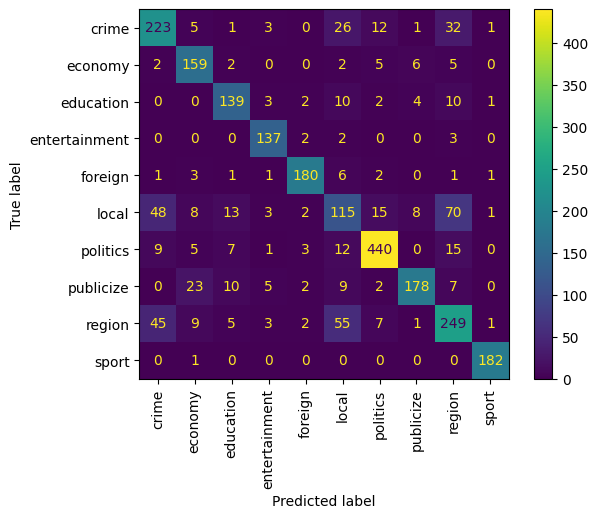

In [25]:
## print confusion matrix
labels = list(label_2_index.keys())

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90)

- the accuracy is not so different from logistic regression
- between two vectorizers, `TfidfVectorizer` is higer F1 score for each category 